a.	Apa saja faktor-faktor yang memengaruhi kemungkinan seorang penumpang selamat dalam tragedi tenggelamnya kapal RMS Titanic?

b.	Bagaimana performa berbagai algoritma machine learning dalam memprediksi keselamatan penumpang Titanic, dan model mana yang paling optimal berdasarkan metrik evaluasi seperti akurasi dan F1-score?

In [26]:
import pandas as pd
import numpy as np

In [27]:
train = pd.read_csv("/content/sample_data/train.csv")
test = pd.read_csv("/content/sample_data/test.csv")

In [28]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [29]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [30]:
print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")
print("\nTrain Info:")
print(train.info())
print("\nTest Info:")
print(test.info())

Train Shape: (891, 12)
Test Shape: (418, 11)

Train Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None

Test Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       ----

In [31]:
print("=== EDA Awal: Missing Values ===")
print("\nTrain Missing Values (%):")
print((train.isnull().sum() / len(train) * 100).round(2))
print("\nTest Missing Values (%):")
print((test.isnull().sum() / len(test) * 100).round(2))

=== EDA Awal: Missing Values ===

Train Missing Values (%):
PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            19.87
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
Cabin          77.10
Embarked        0.22
dtype: float64

Test Missing Values (%):
PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
Age            20.57
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.24
Cabin          78.23
Embarked        0.00
dtype: float64


In [32]:
train['Age'].fillna(train['Age'].median(), inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Fare'].fillna(train['Fare'].median(), inplace=True)

train['HasCabin'] = train['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['HasCabin'] = test['Cabin'].apply(lambda x: 0 if pd.isnull(x) else 1)

train['IsMale'] = pd.get_dummies(train['Sex'], drop_first=True).astype(float)
test['IsMale'] = pd.get_dummies(test['Sex'], drop_first=True).astype(float)

embarked_train = pd.get_dummies(train['Embarked'], prefix='Embarked', drop_first=True).astype(float)
embarked_test = pd.get_dummies(test['Embarked'], prefix='Embarked', drop_first=True).astype(float)
train = pd.concat([train, embarked_train], axis=1)
test = pd.concat([test, embarked_test], axis=1)

train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1
train['IsAlone'] = train['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
test['IsAlone'] = test['FamilySize'].apply(lambda x: 1 if x == 1 else 0)
train['FarePerPerson'] = train['Fare'] / train['FamilySize']
test['FarePerPerson'] = test['Fare'] / test['FamilySize']

def extract_title(name):
    if 'Mr.' in name: return 'Mr'
    elif 'Mrs.' in name: return 'Mrs'
    elif 'Miss.' in name: return 'Miss'
    elif 'Master.' in name: return 'Master'
    else: return 'Other'

train['Title'] = train['Name'].apply(extract_title)
test['Title'] = test['Name'].apply(extract_title)
for title in ['Mr', 'Mrs', 'Miss', 'Master']:
    train[f'Title_{title}'] = train['Title'].apply(lambda x: 1 if x == title else 0)
    test[f'Title_{title}'] = test['Title'].apply(lambda x: 1 if x == title else 0)

test_passenger_id = test['PassengerId']
train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'Title'], axis=1, inplace=True)
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'Title'], axis=1, inplace=True)



<ipython-input-32-2844645502>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Age'].fillna(train['Age'].median(), inplace=True)
<ipython-input-32-2844645502>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [33]:
print("=== EDA Awal: Missing Values ===")
print("\nTrain Missing Values (%):")
print((train.isnull().sum() / len(train) * 100).round(2))
print("\nTest Missing Values (%):")
print((test.isnull().sum() / len(test) * 100).round(2))

=== EDA Awal: Missing Values ===

Train Missing Values (%):
Survived         0.0
Pclass           0.0
Age              0.0
SibSp            0.0
Parch            0.0
Fare             0.0
HasCabin         0.0
IsMale           0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
IsAlone          0.0
FarePerPerson    0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Miss       0.0
Title_Master     0.0
dtype: float64

Test Missing Values (%):
Pclass           0.0
Age              0.0
SibSp            0.0
Parch            0.0
Fare             0.0
HasCabin         0.0
IsMale           0.0
Embarked_Q       0.0
Embarked_S       0.0
FamilySize       0.0
IsAlone          0.0
FarePerPerson    0.0
Title_Mr         0.0
Title_Mrs        0.0
Title_Miss       0.0
Title_Master     0.0
dtype: float64


In [34]:
print("=== EDA Awal: Statistik Deskriptif (Train) ===")
print(train.describe(include='all'))

=== EDA Awal: Statistik Deskriptif (Train) ===
         Survived      Pclass         Age       SibSp       Parch        Fare  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.383838    2.308642   29.361582    0.523008    0.381594   32.204208   
std      0.486592    0.836071   13.019697    1.102743    0.806057   49.693429   
min      0.000000    1.000000    0.420000    0.000000    0.000000    0.000000   
25%      0.000000    2.000000   22.000000    0.000000    0.000000    7.910400   
50%      0.000000    3.000000   28.000000    0.000000    0.000000   14.454200   
75%      1.000000    3.000000   35.000000    1.000000    0.000000   31.000000   
max      1.000000    3.000000   80.000000    8.000000    6.000000  512.329200   

         HasCabin      IsMale  Embarked_Q  Embarked_S  FamilySize     IsAlone  \
count  891.000000  891.000000  891.000000  891.000000  891.000000  891.000000   
mean     0.228956    0.647587    0.086420    0.725028    1.90

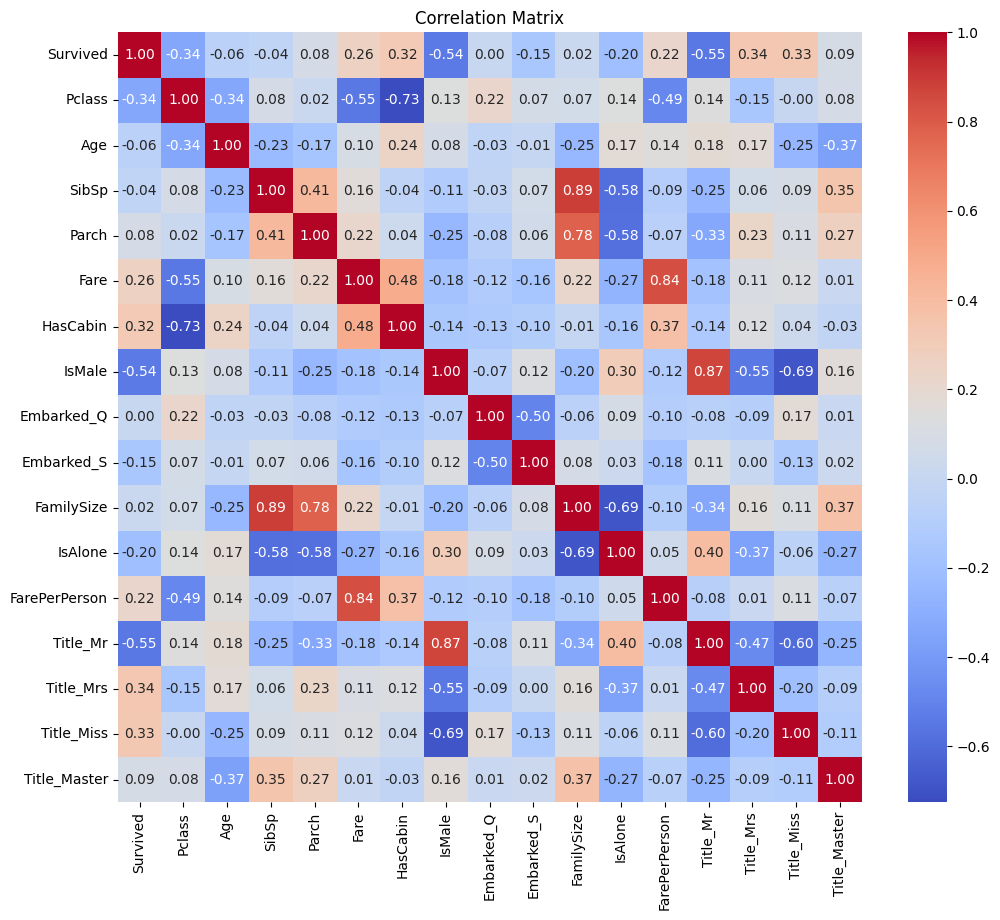

Fitur korelasi rendah: ['SibSp', 'Embarked_Q', 'FamilySize']


In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = train.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

low_corr_features = [col for col in train.columns if abs(corr['Survived'][col]) < 0.05 and col != 'Survived']
print("Fitur korelasi rendah:", low_corr_features)

train.drop(low_corr_features, axis=1, inplace=True)
test.drop(low_corr_features, axis=1, inplace=True)



<ipython-input-36-1241490005>:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
<ipython-input-36-1241490005>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)'

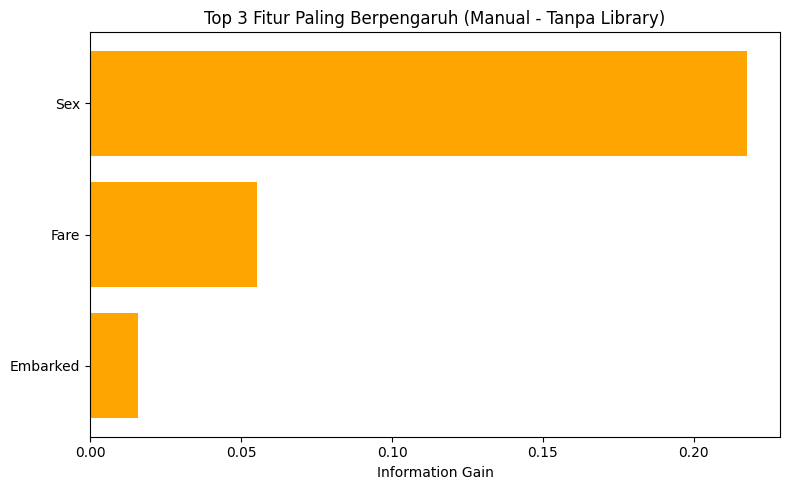

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/content/sample_data/train.csv")

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)
df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
X = df[features]
y = df['Survived']

def entropy(y):
    probs = y.value_counts(normalize=True)
    return -np.sum(probs * np.log2(probs))

def information_gain(data, feature, target):
    total_entropy = entropy(data[target])
    values = data[feature].unique()

    weighted_entropy = 0
    for v in values:
        subset = data[data[feature] == v]
        weighted_entropy += (len(subset)/len(data)) * entropy(subset[target])

    return total_entropy - weighted_entropy

info_gains = {}
for feature in features:
    if df[feature].dtype != 'int64' and df[feature].dtype != 'float64':
        gain = information_gain(df, feature, 'Survived')
    else:
        median = df[feature].median()
        temp = df.copy()
        temp[feature] = (temp[feature] > median).astype(int)
        gain = information_gain(temp, feature, 'Survived')

    info_gains[feature] = gain

importance_df = pd.DataFrame(list(info_gains.items()), columns=['Fitur', 'Pentingnya'])
top3_df = importance_df.sort_values(by='Pentingnya', ascending=False).head(3)

plt.figure(figsize=(8, 5))
plt.barh(top3_df['Fitur'], top3_df['Pentingnya'], color='orange')
plt.xlabel("Information Gain")
plt.title("Top 3 Fitur Paling Berpengaruh (Manual - Tanpa Library)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [37]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.05, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.costs = []

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def _cost_function(self, h, y):
        m = len(y)
        w1, w0 = 1.5, 1.0
        cost = (-1/m) * np.sum((w1 * y * np.log(h + 1e-8)) + (w0 * (1 - y) * np.log(1 - h + 1e-8)))
        return cost

    def fit(self, X, y):
        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0

        for i in range(self.num_iterations):
            z = np.dot(X, self.weights) + self.bias
            h = self._sigmoid(z)
            cost = self._cost_function(h, y)
            self.costs.append(cost)

            dw = (1/m) * np.dot(X.T, (h - y))
            db = (1/m) * np.sum(h - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if i > 1 and abs(self.costs[-2] - self.costs[-1]) < 1e-6:
                print(f"Early stopping at iteration {i}, small cost change.")
                break

            if i % 100 == 0:
                print(f"Iteration {i}, Cost: {cost:.4f}")

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self._sigmoid(z)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

def precision_recall(y_true, y_pred):
    TP = np.sum((y_true == 1) & (y_pred == 1))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))
    precision = TP / (TP + FP + 1e-8)
    recall = TP / (TP + FN + 1e-8)
    return precision, recall

def standardize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / (std + 1e-8)

def train_val_split(df, test_size=0.2):
    split_index = int(len(df) * (1 - test_size))
    train_df = df.iloc[:split_index]
    val_df = df.iloc[split_index:]
    return train_df, val_df

train_df, val_df = train_val_split(train)
X_train = standardize(train_df.drop('Survived', axis=1).values.astype(float))
y_train = train_df['Survived'].values.astype(float)
X_val = standardize(val_df.drop('Survived', axis=1).values.astype(float))
y_val = val_df['Survived'].values.astype(float)
X_test = standardize(test.values.astype(float))

model = LogisticRegressionScratch(learning_rate=0.05, num_iterations=10000)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
acc = accuracy(y_val, y_pred_val)
prec, rec = precision_recall(y_val, y_pred_val)
print(f"Akurasi: {acc:.4f}, Presisi: {prec:.4f}, Recall: {rec:.4f}")

model.fit(train.drop('Survived', axis=1).values.astype(float), train['Survived'].values.astype(float))
predictions_test = model.predict(X_test)


Iteration 0, Cost: 0.8285
Iteration 100, Cost: 0.5665
Iteration 200, Cost: 0.5581
Iteration 300, Cost: 0.5570
Early stopping at iteration 324, small cost change.
Akurasi: 0.8659, Presisi: 0.8125, Recall: 0.8125
Iteration 0, Cost: 0.8262
Iteration 100, Cost: 9.5112
Iteration 200, Cost: 9.2297
Iteration 300, Cost: 10.0130
Iteration 400, Cost: 9.1050
Iteration 500, Cost: 3.4677
Iteration 600, Cost: 10.1209
Iteration 700, Cost: 2.9761
Iteration 800, Cost: 7.8724
Iteration 900, Cost: 7.7388
Iteration 1000, Cost: 4.4613
Iteration 1100, Cost: 6.3939
Iteration 1200, Cost: 6.7156
Iteration 1300, Cost: 6.7103
Iteration 1400, Cost: 5.4269
Iteration 1500, Cost: 6.2340
Iteration 1600, Cost: 6.4931
Iteration 1700, Cost: 4.5406
Iteration 1800, Cost: 5.3859
Iteration 1900, Cost: 4.8093
Iteration 2000, Cost: 5.3854
Iteration 2100, Cost: 5.6044
Iteration 2200, Cost: 4.5208
Iteration 2300, Cost: 4.8967
Iteration 2400, Cost: 4.6181
Iteration 2500, Cost: 4.0658
Iteration 2600, Cost: 4.0479
Iteration 2700, 

In [38]:
model = LogisticRegressionScratch(learning_rate=0.05, num_iterations=10000)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
acc = accuracy(y_val, y_pred_val)
prec, rec = precision_recall(y_val, y_pred_val)
print(f"Akurasi: {acc:.4f}, Presisi: {prec:.4f}, Recall: {rec:.4f}")

Iteration 0, Cost: 0.8285
Iteration 100, Cost: 0.5665
Iteration 200, Cost: 0.5581
Iteration 300, Cost: 0.5570
Early stopping at iteration 324, small cost change.
Akurasi: 0.8659, Presisi: 0.8125, Recall: 0.8125


In [39]:
def f1_score(y_true, y_pred):
    precision, recall = precision_recall(y_true, y_pred)
    return 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

In [40]:
train['Fare_Age'] = train['Fare'] * train['Age']
test['Fare_Age'] = test['Fare'] * test['Age']

train['Pclass_Sex'] = train['Pclass'] * train['IsMale']
test['Pclass_Sex'] = test['Pclass'] * test['IsMale']

train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'Title'], axis=1, inplace=True, errors='ignore')
test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin', 'Sex', 'Embarked', 'Title'], axis=1, inplace=True, errors='ignore')

train_df, val_df = train_val_split(train)
X_train = standardize(train_df.drop('Survived', axis=1).values.astype(float))
y_train = train_df['Survived'].values.astype(float)
X_val = standardize(val_df.drop('Survived', axis=1).values.astype(float))
y_val = val_df['Survived'].values.astype(float)
X_test = standardize(test.values.astype(float))

model = LogisticRegressionScratch(learning_rate=0.01, num_iterations=10000)
model.fit(X_train, y_train)

print("\nEksperimen berbagai threshold:")
for threshold in [0.5, 0.45, 0.4, 0.35, 0.6,0.7]:
    y_pred_val = model.predict(X_val, threshold=threshold)
    acc = accuracy(y_val, y_pred_val)
    prec, rec = precision_recall(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    print(f"Threshold {threshold:.2f} → Akurasi: {acc:.4f}, Presisi: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")


Iteration 0, Cost: 0.8285
Iteration 100, Cost: 0.6339
Iteration 200, Cost: 0.5933
Iteration 300, Cost: 0.5788
Iteration 400, Cost: 0.5715
Iteration 500, Cost: 0.5673
Iteration 600, Cost: 0.5646
Iteration 700, Cost: 0.5629
Iteration 800, Cost: 0.5617
Iteration 900, Cost: 0.5610
Iteration 1000, Cost: 0.5605
Iteration 1100, Cost: 0.5602
Iteration 1200, Cost: 0.5600
Early stopping at iteration 1251, small cost change.

Eksperimen berbagai threshold:
Threshold 0.50 → Akurasi: 0.8603, Presisi: 0.8095, Recall: 0.7969, F1: 0.8031
Threshold 0.45 → Akurasi: 0.8212, Presisi: 0.7162, Recall: 0.8281, F1: 0.7681
Threshold 0.40 → Akurasi: 0.7933, Presisi: 0.6667, Recall: 0.8437, F1: 0.7448
Threshold 0.35 → Akurasi: 0.7933, Presisi: 0.6552, Recall: 0.8906, F1: 0.7550
Threshold 0.60 → Akurasi: 0.8268, Presisi: 0.8113, Recall: 0.6719, F1: 0.7350
Threshold 0.70 → Akurasi: 0.8436, Presisi: 0.9091, Recall: 0.6250, F1: 0.7407


In [41]:
class KNNClassifier:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _euclidean_distance(self, x1, x2):
        return np.sqrt(np.sum((x1 - x2) ** 2))

    def predict(self, X_test):
        y_pred = []
        for x_test in X_test:
            distances = [self._euclidean_distance(x_test, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            most_common = np.bincount(k_nearest_labels.astype(int)).argmax()
            y_pred.append(most_common)
        return np.array(y_pred)


In [42]:
knn = KNNClassifier(k=5)
knn.fit(X_train, y_train)

y_pred_val_knn = knn.predict(X_val)
acc_knn = accuracy(y_val, y_pred_val_knn)
prec_knn, rec_knn = precision_recall(y_val, y_pred_val_knn)

print(f"[KNN] Akurasi: {acc_knn:.4f}, Presisi: {prec_knn:.4f}, Recall: {rec_knn:.4f}")


[KNN] Akurasi: 0.8547, Presisi: 0.8276, Recall: 0.7500


In [43]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-6
            self.priors[c] = X_c.shape[0] / X.shape[0]

    def _gaussian_pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        y_pred = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.priors[c])
                likelihoods = np.sum(np.log(self._gaussian_pdf(c, x)))
                posterior = prior + likelihoods
                posteriors.append(posterior)
            y_pred.append(self.classes[np.argmax(posteriors)])
        return np.array(y_pred)


In [44]:
nb = NaiveBayes()
nb.fit(X_train, y_train)

y_pred_val_nb = nb.predict(X_val)
acc_nb = accuracy(y_val, y_pred_val_nb)
prec_nb, rec_nb = precision_recall(y_val, y_pred_val_nb)
print(f"[Naive Bayes] Akurasi: {acc_nb:.4f}, Presisi: {prec_nb:.4f}, Recall: {rec_nb:.4f}")


[Naive Bayes] Akurasi: 0.8212, Presisi: 0.7424, Recall: 0.7656


In [45]:
class DecisionTreeNode:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree:
    def fit(self, X, y, depth=0, max_depth=5):
        self.root = self._build_tree(X, y, depth, max_depth)

    def _gini(self, y):
        classes = np.unique(y)
        gini = 1.0
        for c in classes:
            p = np.sum(y == c) / len(y)
            gini -= p ** 2
        return gini

    def _best_split(self, X, y):
        best_feature, best_thresh, best_gini = None, None, float('inf')
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for t in thresholds:
                left_idx = X[:, feature] <= t
                right_idx = X[:, feature] > t
                if len(y[left_idx]) == 0 or len(y[right_idx]) == 0:
                    continue
                gini = (len(y[left_idx]) * self._gini(y[left_idx]) +
                        len(y[right_idx]) * self._gini(y[right_idx])) / len(y)
                if gini < best_gini:
                    best_feature, best_thresh, best_gini = feature, t, gini
        return best_feature, best_thresh

    def _build_tree(self, X, y, depth, max_depth):
        if len(np.unique(y)) == 1 or depth == max_depth:
            leaf_value = np.bincount(y.astype(int)).argmax()
            return DecisionTreeNode(value=leaf_value)

        feature, threshold = self._best_split(X, y)
        if feature is None:
            leaf_value = np.bincount(y.astype(int)).argmax()
            return DecisionTreeNode(value=leaf_value)

        left_idx = X[:, feature] <= threshold
        right_idx = X[:, feature] > threshold
        left = self._build_tree(X[left_idx], y[left_idx], depth+1, max_depth)
        right = self._build_tree(X[right_idx], y[right_idx], depth+1, max_depth)
        return DecisionTreeNode(feature, threshold, left, right)

    def _predict_sample(self, x, tree):
        if tree.value is not None:
            return tree.value
        if x[tree.feature] <= tree.threshold:
            return self._predict_sample(x, tree.left)
        else:
            return self._predict_sample(x, tree.right)

    def predict(self, X):
        return np.array([self._predict_sample(x, self.root) for x in X])


In [46]:
tree = DecisionTree()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_val)
acc_tree = accuracy(y_val, y_pred_tree)
prec_tree, rec_tree = precision_recall(y_val, y_pred_tree)
print(f"[Decision Tree] Akurasi: {acc_tree:.4f}, Presisi: {prec_tree:.4f}, Recall: {rec_tree:.4f}")


[Decision Tree] Akurasi: 0.8603, Presisi: 0.8421, Recall: 0.7500


In [47]:

def accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def precision_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))

    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall    = tp / (tp + fn) if (tp + fn) != 0 else 0
    return precision, recall

def f1_score(y_true, y_pred):
    precision, recall = precision_recall(y_true, y_pred)
    return 2 * precision * recall / (precision + recall) if (precision + recall) != 0 else 0

log_model = LogisticRegressionScratch(learning_rate=0.05, num_iterations=1000)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_val)
print("[Logistic Regression]")
print(f"Akurasi : {accuracy(y_val, y_pred_log):.4f}")
prec, rec = precision_recall(y_val, y_pred_log)
print(f"Presisi : {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_score(y_val, y_pred_log):.4f}\n")

knn = KNNClassifier(k=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_val)
print("[KNN]")
print(f"Akurasi : {accuracy(y_val, y_pred_knn):.4f}")
prec, rec = precision_recall(y_val, y_pred_knn)
print(f"Presisi : {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_score(y_val, y_pred_knn):.4f}\n")

nb = NaiveBayes()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_val)
print("[Naive Bayes]")
print(f"Akurasi : {accuracy(y_val, y_pred_nb):.4f}")
prec, rec = precision_recall(y_val, y_pred_nb)
print(f"Presisi : {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_score(y_val, y_pred_nb):.4f}\n")

tree = DecisionTree()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_val)
print("[Decision Tree]")
print(f"Akurasi : {accuracy(y_val, y_pred_tree):.4f}")
prec, rec = precision_recall(y_val, y_pred_tree)
print(f"Presisi : {prec:.4f}, Recall: {rec:.4f}, F1 Score: {f1_score(y_val, y_pred_tree):.4f}")


Iteration 0, Cost: 0.8285
Iteration 100, Cost: 0.5672
Iteration 200, Cost: 0.5605
Early stopping at iteration 294, small cost change.
[Logistic Regression]
Akurasi : 0.8603
Presisi : 0.8095, Recall: 0.7969, F1 Score: 0.8031

[KNN]
Akurasi : 0.8547
Presisi : 0.8276, Recall: 0.7500, F1 Score: 0.7869

[Naive Bayes]
Akurasi : 0.8212
Presisi : 0.7424, Recall: 0.7656, F1 Score: 0.7538

[Decision Tree]
Akurasi : 0.8603
Presisi : 0.8421, Recall: 0.7500, F1 Score: 0.7934


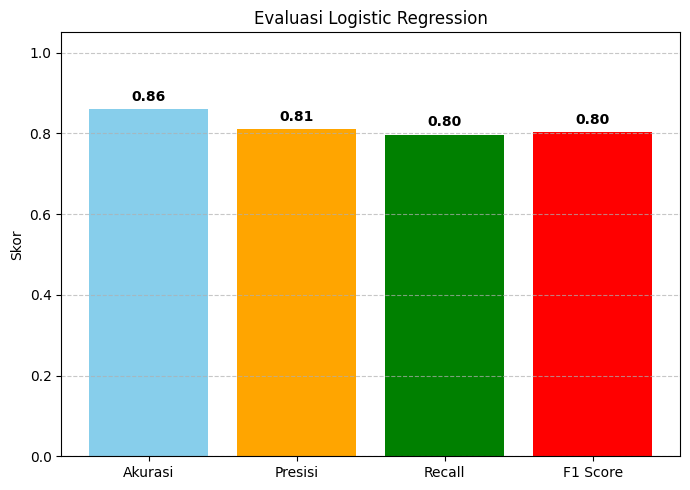

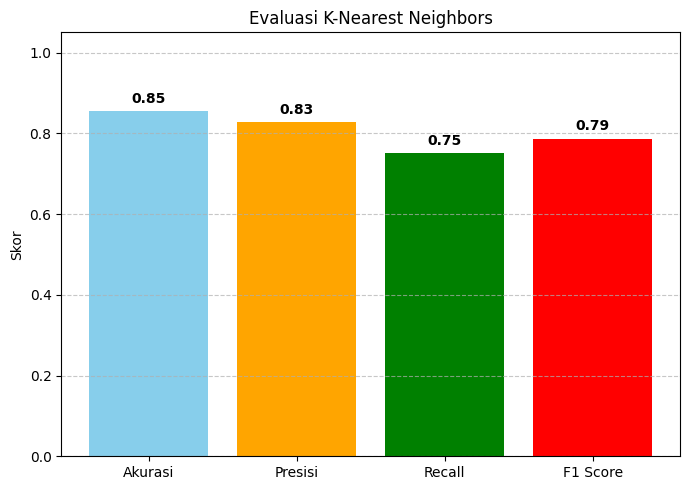

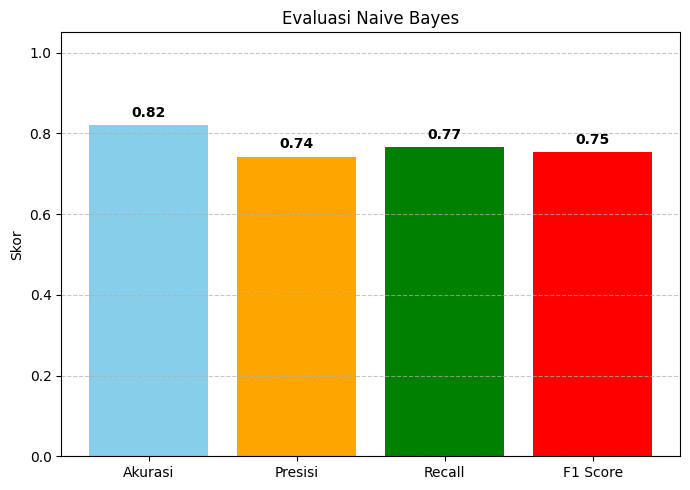

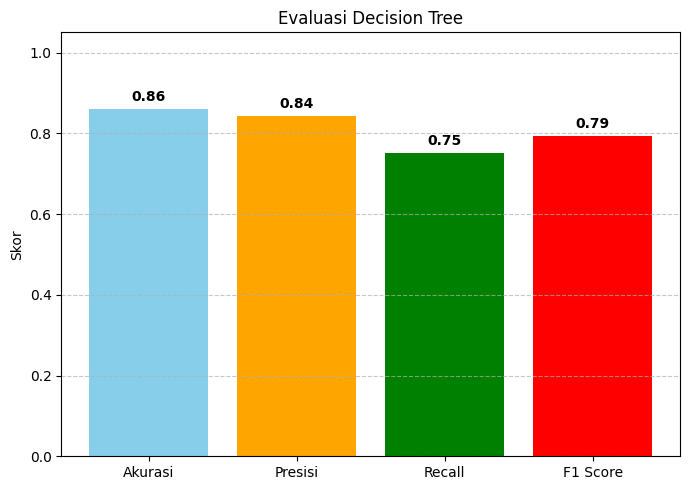

In [48]:
import matplotlib.pyplot as plt

model_names = [
    'Logistic Regression',
    'K-Nearest Neighbors',
    'Naive Bayes',
    'Decision Tree'
]

akurasi = [
    accuracy(y_val, y_pred_log),
    accuracy(y_val, y_pred_knn),
    accuracy(y_val, y_pred_nb),
    accuracy(y_val, y_pred_tree)
]

presisi = [
    precision_recall(y_val, y_pred_log)[0],
    precision_recall(y_val, y_pred_knn)[0],
    precision_recall(y_val, y_pred_nb)[0],
    precision_recall(y_val, y_pred_tree)[0]
]

recall = [
    precision_recall(y_val, y_pred_log)[1],
    precision_recall(y_val, y_pred_knn)[1],
    precision_recall(y_val, y_pred_nb)[1],
    precision_recall(y_val, y_pred_tree)[1]
]

f1 = [
    f1_score(y_val, y_pred_log),
    f1_score(y_val, y_pred_knn),
    f1_score(y_val, y_pred_nb),
    f1_score(y_val, y_pred_tree)
]

for i in range(len(model_names)):
    metrics = [akurasi[i], presisi[i], recall[i], f1[i]]
    metric_names = ['Akurasi', 'Presisi', 'Recall', 'F1 Score']
    plt.figure(figsize=(7, 5))
    bars = plt.bar(metric_names, metrics, color=['skyblue', 'orange', 'green', 'red'])
    plt.ylim(0, 1.05)
    plt.title(f'Evaluasi {model_names[i]}')
    plt.ylabel('Skor')
    for j, v in enumerate(metrics):
        plt.text(j, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

<ipython-input-49-3287969561>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-49-3287969561>:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

K=1, WCSS=2518.05
K=2, WCSS=1977.66
K=3, WCSS=1189.43
K=4, WCSS=888.45
K=5, WCSS=797.43
K=6, WCSS=715.11
K=7, WCSS=677.67
K=8, WCSS=578.17
K=9, WCSS=549.44
K=10, WCSS=519.93


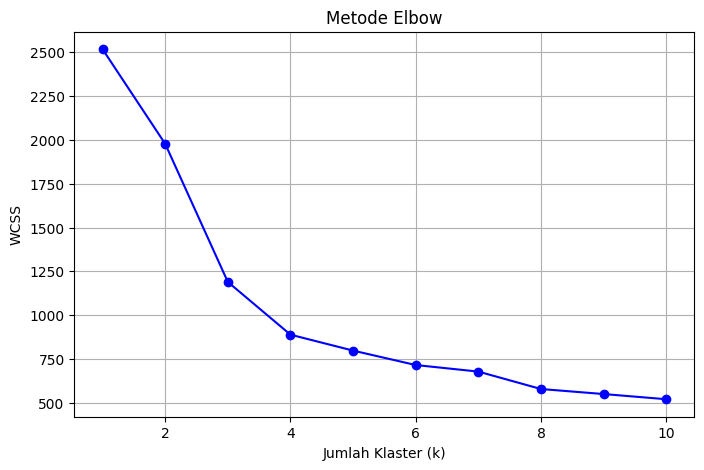


===== EKSPERIMEN KMEANS DENGAN BERBAGAI NILAI k =====

Evaluasi untuk k=2:
  Akurasi  : 0.6667
  Presisi  : 0.5575
  Recall   : 0.6374
  F1-Score : 0.5948


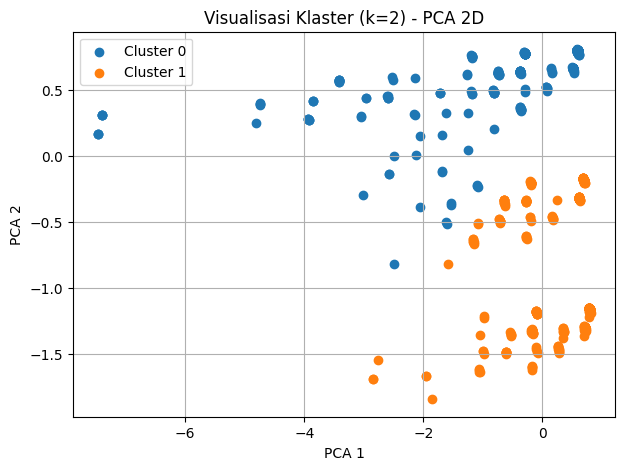


Evaluasi untuk k=3:
  Akurasi  : 0.6762
  Presisi  : 0.6552
  Recall   : 0.9330
  F1-Score : 0.7698


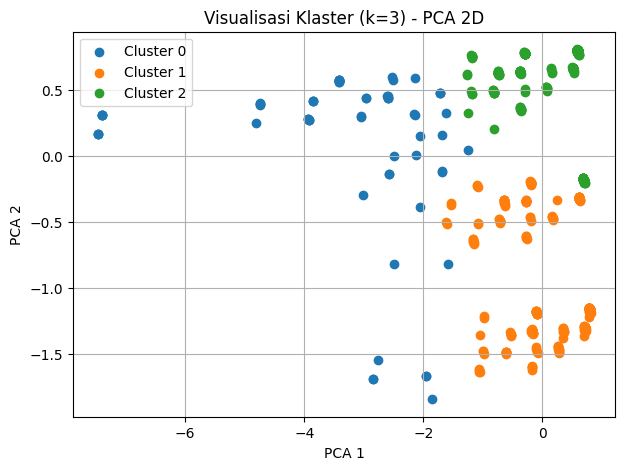


Evaluasi untuk k=4:
  Akurasi  : 0.7006
  Presisi  : 0.6396
  Recall   : 0.9103
  F1-Score : 0.7513


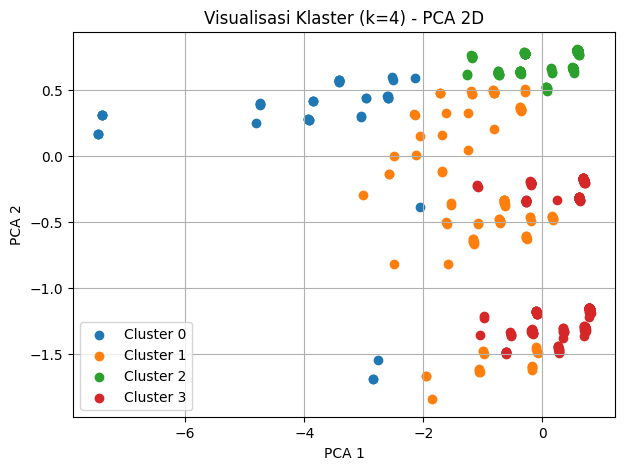

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


train_df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")
combined_df = pd.concat([train_df, test_df], ignore_index=True)

features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']
df = combined_df[features].copy()

df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

df['Age'].fillna(df['Age'].median(), inplace=True)
df['Fare'].fillna(df['Fare'].median(), inplace=True)

for col in ['Age', 'Fare']:
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

X = df.to_numpy()

def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

def initialize_centroids_fixed(data, k):
    return data[:k]

def kmeans_wcss_manual(data, k, max_iters=100):
    centroids = initialize_centroids_fixed(data, k)
    for _ in range(max_iters):
        clusters = []
        for point in data:
            distances = [euclidean_distance(point, centroid) for centroid in centroids]
            clusters.append(np.argmin(distances))
        clusters = np.array(clusters)

        new_centroids = []
        for i in range(k):
            points = data[clusters == i]
            if len(points) > 0:
                new_centroids.append(np.mean(points, axis=0))
            else:
                new_centroids.append(centroids[i])
        new_centroids = np.array(new_centroids)

        if np.allclose(centroids, new_centroids):
            break
        centroids = new_centroids


    total_wcss = 0
    for i in range(k):
        points = data[clusters == i]
        total_wcss += np.sum([euclidean_distance(p, centroids[i])**2 for p in points])

    return total_wcss, clusters

def elbow_method(data, max_k=10):
    wcss_values = []
    for k in range(1, max_k+1):
        wcss, _ = kmeans_wcss_manual(data, k)
        wcss_values.append(wcss)
        print(f"K={k}, WCSS={wcss:.2f}")

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, max_k+1), wcss_values, 'bo-')
    plt.xlabel("Jumlah Klaster (k)")
    plt.ylabel("WCSS")
    plt.title("Metode Elbow")
    plt.grid(True)
    plt.show()

def pca_2d(X):
    X_meaned = X - np.mean(X, axis=0)
    cov_mat = np.cov(X_meaned, rowvar=False)
    eig_vals, eig_vecs = np.linalg.eigh(cov_mat)
    top2 = np.argsort(eig_vals)[::-1][:2]
    return X_meaned @ eig_vecs[:, top2]

def evaluate_clustering(y_true, y_pred):
    def compute_metrics(y1, y2):
        TP = np.sum((y1 == 1) & (y2 == 1))
        TN = np.sum((y1 == 0) & (y2 == 0))
        FP = np.sum((y1 == 0) & (y2 == 1))
        FN = np.sum((y1 == 1) & (y2 == 0))

        accuracy = (TP + TN) / (TP + TN + FP + FN)
        precision = TP / (TP + FP) if TP + FP > 0 else 0
        recall = TP / (TP + FN) if TP + FN > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        return accuracy, precision, recall, f1

    acc1, prec1, rec1, f1_1 = compute_metrics(y_true, y_pred)
    acc2, prec2, rec2, f1_2 = compute_metrics(y_true, 1 - y_pred)

    if f1_1 >= f1_2:
        return acc1, prec1, rec1, f1_1
    else:
        return acc2, prec2, rec2, f1_2

survived_labels = train_df['Survived'].values
X_train_only = X[:len(survived_labels)]

elbow_method(X_train_only, max_k=10)

print("\n===== EKSPERIMEN KMEANS DENGAN BERBAGAI NILAI k =====")
for k in [2, 3, 4]:
    _, clusters = kmeans_wcss_manual(X_train_only, k=k)

    acc, prec, rec, f1 = evaluate_clustering(survived_labels, clusters)
    print(f"\nEvaluasi untuk k={k}:")
    print(f"  Akurasi  : {acc:.4f}")
    print(f"  Presisi  : {prec:.4f}")
    print(f"  Recall   : {rec:.4f}")
    print(f"  F1-Score : {f1:.4f}")

    X_pca = pca_2d(X_train_only)
    plt.figure(figsize=(7, 5))
    for cluster_id in np.unique(clusters):
        plt.scatter(
            X_pca[clusters == cluster_id, 0],
            X_pca[clusters == cluster_id, 1],
            label=f'Cluster {cluster_id}'
        )
    plt.title(f"Visualisasi Klaster (k={k}) - PCA 2D")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend()
    plt.grid(True)
    plt.show()
